In [1]:
# Import neccesary modules
# Set matplotlib to inline mode for the Jupyter notebook visualisations

%matplotlib inline

import rospy
from sensor_msgs.msg import LaserScan
from nav_msgs.srv import GetMap
from nav_msgs.msg import OccupancyGrid

import numpy as np
import matplotlib.pyplot as plt

import numpy as np

import copy
import time
import math


resolution = 1

# Helper method for retrieving the map
def getMap() -> OccupancyGrid:
    """ Loads map from map service """
    # Create service proxy
    get_map = rospy.ServiceProxy('static_map', GetMap)
    # Call service
    recMap = get_map()
    recMap = recMap.map
    resolution = recMap.info.resolution
    # Return
    return recMap

def laserScanSubCallback(msg):
    """ Loads the laserscan from message """
    ranges = np.array(msg.ranges)
    angle = msg.angle_min
    increment = msg.angle_increment
    i = 0
    
    x_coords = np.array([])
    for range in ranges:
        x = math.sin(angle)*range + resolution/2
        x_coords = np.append(x_coords, round(x))
        angle += increment
    global scan
    scan = x_coords[np.newaxis, :]

    y_coords = np.array([])
    angle = msg.angle_min
    for range in ranges:
        y = math.cos(angle)*range + resolution/2
        y_coords = np.append(y_coords, round(y))
        angle += increment
    scan = np.vstack((scan, y_coords))

laserScanSub = rospy.Subscriber("/scan", LaserScan, laserScanSubCallback)

# Initiate ROS node
rospy.init_node('mazeEscape')
recMap = getMap()

# convert the data to a 2d array (coordinates)
mapData = np.array(recMap.data)
recMap = np.split(mapData, recMap.info.width)

rospy.wait_for_message("/scan", LaserScan, 999999999)

# iterate over the recMap cells and add each to a corresponding list
# according to whether it is a wall or free space

# the arrays to hold the empty and wall cells in the map
global wallPositions
global freePositions

x_coords_free = np.array([])
y_coords_free = np.array([])
x_coords_wall = np.array([])
y_coords_wall = np.array([])

# iteration counters
x:int = 0 
y:int = 0

# free space and wall counters
free_count = 0
wall_count = 0

for row in recMap:
    for cell in row:
        if cell < 5:
            # add to empty space list
            x_coords_free = np.append(x_coords_free, x)
            y_coords_free = np.append(y_coords_free, y)
            free_count += 1
        else:
            # add to wall list
            x_coords_wall = np.append(x_coords_wall, x)
            y_coords_wall = np.append(y_coords_wall, y)
            wall_count += 1
        y += 1
    y = 0
    x += 1

freePositions = np.array([[x_coords_free[0], y_coords_free[0]]])
i = 1
while(i < free_count):
    pos = np.array([[x_coords_free[i], y_coords_free[i]]])
    freePositions = np.vstack((freePositions, pos))
    i += 1

wallPositions = np.array([[x_coords_wall[0], y_coords_wall[0]]])
i = 1
while(i < wall_count):
    pos = np.array([[x_coords_wall[i], y_coords_wall[i]]])
    wallPositions = np.vstack((wallPositions, pos))
    i += 1

scan = np.array([[1, 1], [2, 2], [3, 3], [3, 4], [3, 5], [4, 5], [5, 5]])

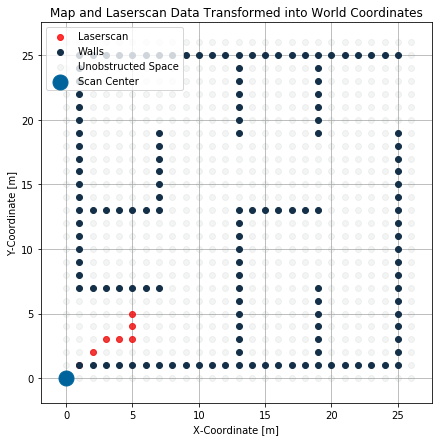

In [2]:
# Store colours matching UAS TW colour scheme as dict 
colourScheme = {
    "darkblue": "#143049",
    "twblue": "#00649C",
    "lightblue": "#8DA3B3",
    "lightgrey": "#CBC0D5",
    "twgrey": "#72777A"
}

## Visualise transformed maze and scans
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

# Plot data as points (=scatterplot) and label accordingly. The colours are to look nice with UAS TW colours
ax.scatter(scan[:,1], scan[:,0], c="r", alpha=0.8, label="Laserscan")
ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
ax.scatter(freePositions[:,1], freePositions[:,0], c=colourScheme["twgrey"], alpha=0.08, s=6**2, label="Unobstructed Space")
ax.scatter([0], [0], c=colourScheme["twblue"], s=15**2, label="Scan Center")

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Map and Laserscan Data Transformed into World Coordinates")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()